# 1.  Introduction

This dataset is `telco-customer-churn.csv`,  The following is a data dictionary explanation of the dataset:

Header | Definition
---|---
`customerID` | ID for each customer
`gender` | The customer’s gender: Male, Female
`SeniorCitizen` | Indicates if the customer is 65 or older: Yes(1), No(0)
`Partner` | Indicate if the customer has a partner: Yes, No
`Dependents` | Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
`tenure` | Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
`PhoneService` | Indicates if the customer subscribes to home phone service with the company: Yes, No
`MultipleLines` | Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
`InternetService` | Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
`StreamingTV` | Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
`StreamingMovies` | Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
`Contract` | Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
`PaperlessBilling` | Indicates if the customer has chosen paperless billing: Yes, No
`PaymentMethod` | Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
`MonthlyCharges` | Indicates the customer’s current total monthly charge for all their services from the company.
`TotalCharges` | Indicates the customer’s total charges, calculated to the end of the quarter specified above.
`Churn` | Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

### The objective of this model is to predict whether a customer will churn or not.

# 2. Import Library

In [518]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from jcopml.tuning import random_search_params as rsp
from jcopml.utils import save_model, load_model
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease


pd.options.display.max_columns = 100

# this library for avoid warnings
import warnings
pd.set_option('mode.chained_assignment', None)

# this function for round 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# 3. Data Loading

In [519]:
data    = pd.read_csv('telco-customer-churn.csv')
df      = data.copy()

# 4. Data Cleaning

##### berdasarkan pada data dictionary, secara sekilas saya akan menghapus beberapa feature/variable yang menurut saya tidak berkaitan dengan target (churn), yaitu **gender** dan **PaperlessBilling**

In [520]:
df = df.drop(columns=['gender', 'PaperlessBilling'])

## A. Check Missing Values

In [521]:
df.isna().sum()

customerID          0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

##### Terlihat dataset tidak memiliki missing value

## B. Check Data Type

In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


##### SeniorCitizen memiliki tipe data **Int** padahal datanya adalah data **categorical nominal**  sehingga harus diubah menjadi **object**

In [523]:
df['SeniorCitizen'] = np.where(df['SeniorCitizen'] == 0, 'No', 'Yes')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

##### TotalCharge memiliki tipe data **object** yang mana seharusnya adalah **float**, sehingga harus diubah.

In [524]:
df['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

##### Namun penyebab mengapa TotalCharge menjadi object karena ada data yang **kosong** atau hanya berupa **spasi (' ')**, sehingga lebih baik dihapus.

In [525]:
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype('float64')

##### Untuk menghindari hal serupa terjadi, akan lebih baik jika mengecek seluruh tipe categorical.

In [526]:
for i in df.columns:
    if df[i].dtype =='O':
        print(df[i].value_counts())
        print('\n')

7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: customerID, Length: 7032, dtype: int64


No     5890
Yes    1142
Name: SeniorCitizen, dtype: int64


No     3639
Yes    3393
Name: Partner, dtype: int64


No     4933
Yes    2099
Name: Dependents, dtype: int64


Yes    6352
No      680
Name: PhoneService, dtype: int64


No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64


Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64


No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64


No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64


No                     3094
Yes                    2418
No internet service    1520
Name: DevicePr

In [527]:
df.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'],
      dtype='object')

In [528]:
df[df['TechSupport'] == ' ']

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn


##### Dapat dilihat bahwa tidak ada data yang kosong lagi

## C. Check Duplicate Data

In [529]:
df[df.duplicated()]

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn


##### Tidak terlihat adanya data duplicate

# 5. Exploratory Data Analysis

In [530]:
kategorik = [ i for i in df.columns if df[i].dtype =='O']
numerik = [i for i in df.columns if df[i].dtype !='O']

##### Membuat list untuk categoric variable dan numerical variable

## A. Numerical Variables

c:\Users\rizan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


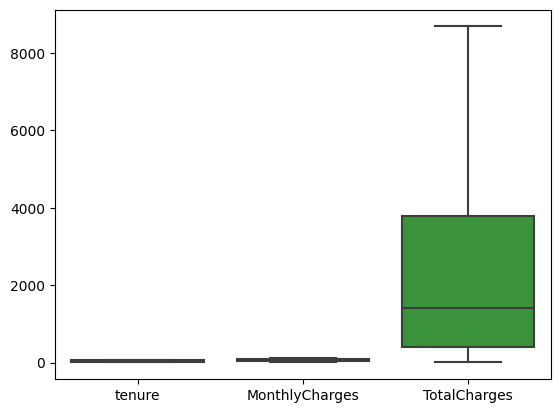

In [575]:
sns.boxplot(df);

##### Terlihat bahwa numerical variable tidak memiliki outliers


In [531]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.00,7032.00,7032.00
mean,32.42,64.80,2283.30
std,24.55,30.09,2266.77
min,1.00,18.25,18.80
25%,9.00,35.59,401.45
50%,29.00,70.35,1397.47
75%,55.00,89.86,3794.74
max,72.00,118.75,8684.80


##### dapat dilihat bahwa rata-rata orang membayar **$64.80** perbulan untuk tagihan telco, sementara dalam satu quarter customer rata-rata membayar **$2283.30**

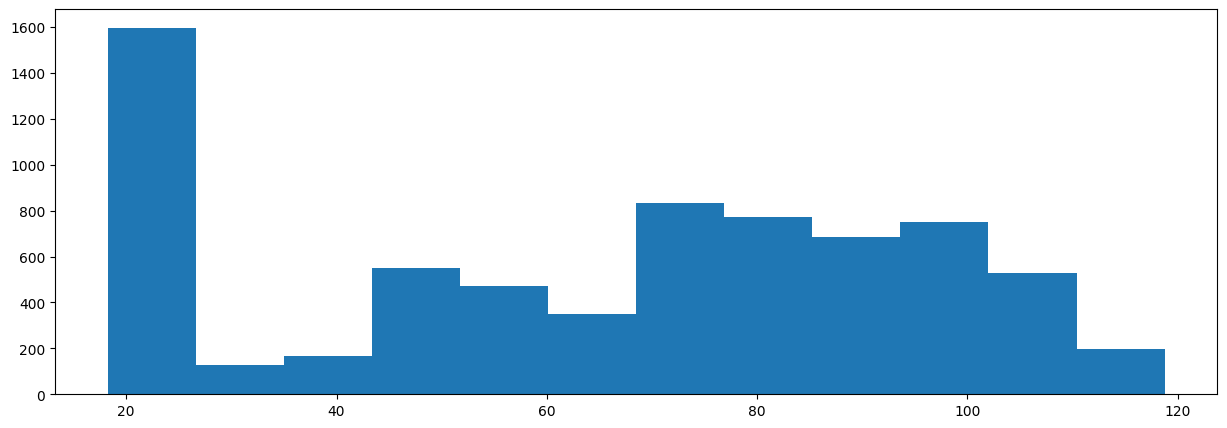

In [579]:
plt.figure(figsize=(15,5))
plt.hist(df['MonthlyCharges'], bins=12);

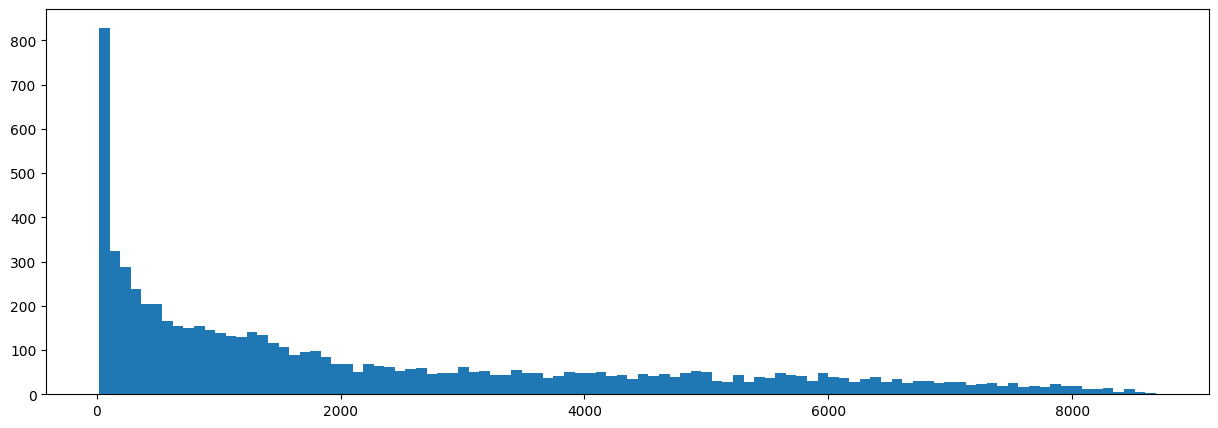

In [580]:
plt.figure(figsize=(15,5))
plt.hist(df['TotalCharges'], bins=100);

In [532]:
df[
    df['TotalCharges'] < 20
].head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
101,3679-XASPY,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Electronic check,19.45,19.45,No
128,3930-ZGWVE,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Mailed check,19.75,19.75,No
310,1098-TDVUQ,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Bank transfer (automatic),19.25,19.25,No
367,7302-ZHMHP,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Mailed check,19.15,19.15,No
408,4800-VHZKI,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Mailed check,19.90,19.90,Yes


##### Customer yang memiliki **MonthlyCharges / TotalCharges** yang **rendah** adalah customer yang **hanya** menggunakan layanan **PhoneService**, namun mereka adalah customer terbanyak yang perusahaan miliki.

<AxesSubplot: xlabel='tenure', ylabel='count'>

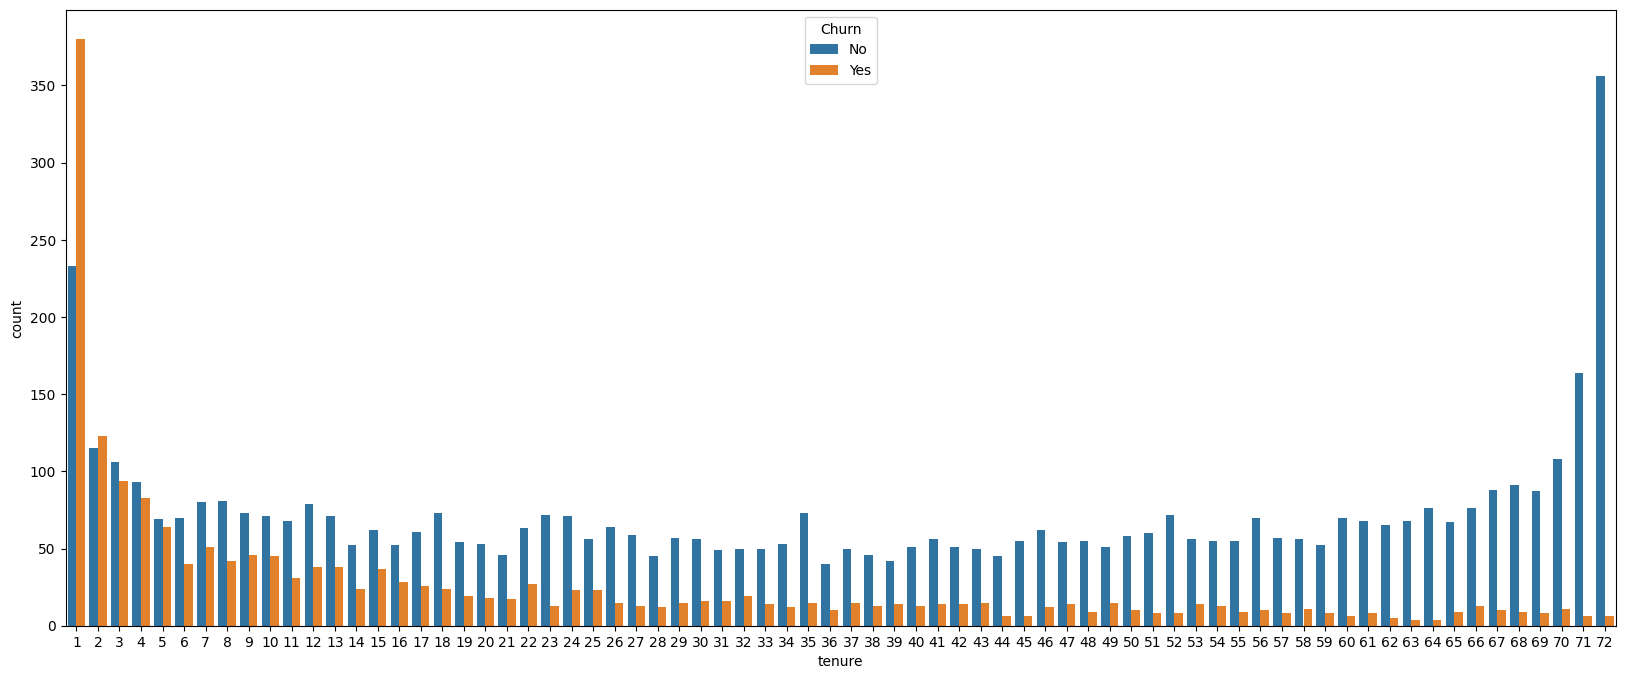

In [533]:
plt.figure(figsize=(20,8))
sns.countplot(data = df, x= 'tenure', hue = 'Churn')

In [584]:
df[
    df['tenure'] == 1
]

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,29.85,29.85,No
20,8779-QRDMV,Yes,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Electronic check,39.65,39.65,Yes
22,1066-JKSGK,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Mailed check,20.15,20.15,Yes
27,8665-UTDHZ,No,Yes,Yes,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,30.20,30.20,Yes
33,7310-EGVHZ,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Bank transfer (automatic),20.20,20.20,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,5351-QESIO,No,No,Yes,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Mailed check,24.20,24.20,No
7010,0723-DRCLG,Yes,Yes,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,74.45,74.45,Yes
7016,1471-GIQKQ,No,No,No,1,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,49.95,49.95,No
7018,1122-JWTJW,No,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Mailed check,70.65,70.65,Yes


- `banyak customer yang pindah setelah bulan pertama, sehingga diperlukan pemeriksaan lebih lanjut`
- `Costumer churn rate akan terus berkurang seiring customer tenure yang lebih lama`
- `Customer yang memiliki tenure yang lama akan cenderung lebih setia, apalagi yang tenure 70 bulan keatas`

<AxesSubplot: xlabel='Churn', ylabel='count'>

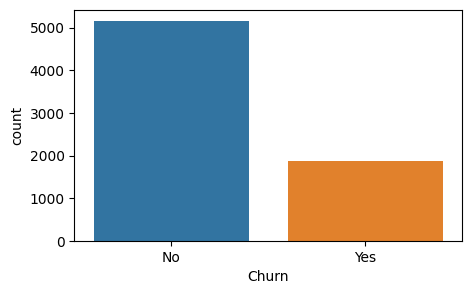

In [539]:
plt.figure(figsize=(5,3))
sns.countplot(x = df['Churn'])

##### Jika melihat kondisi label churn, dapat dilihat bahwa data ini imbalance. Dimana data lebih banyak apada customer yang setia

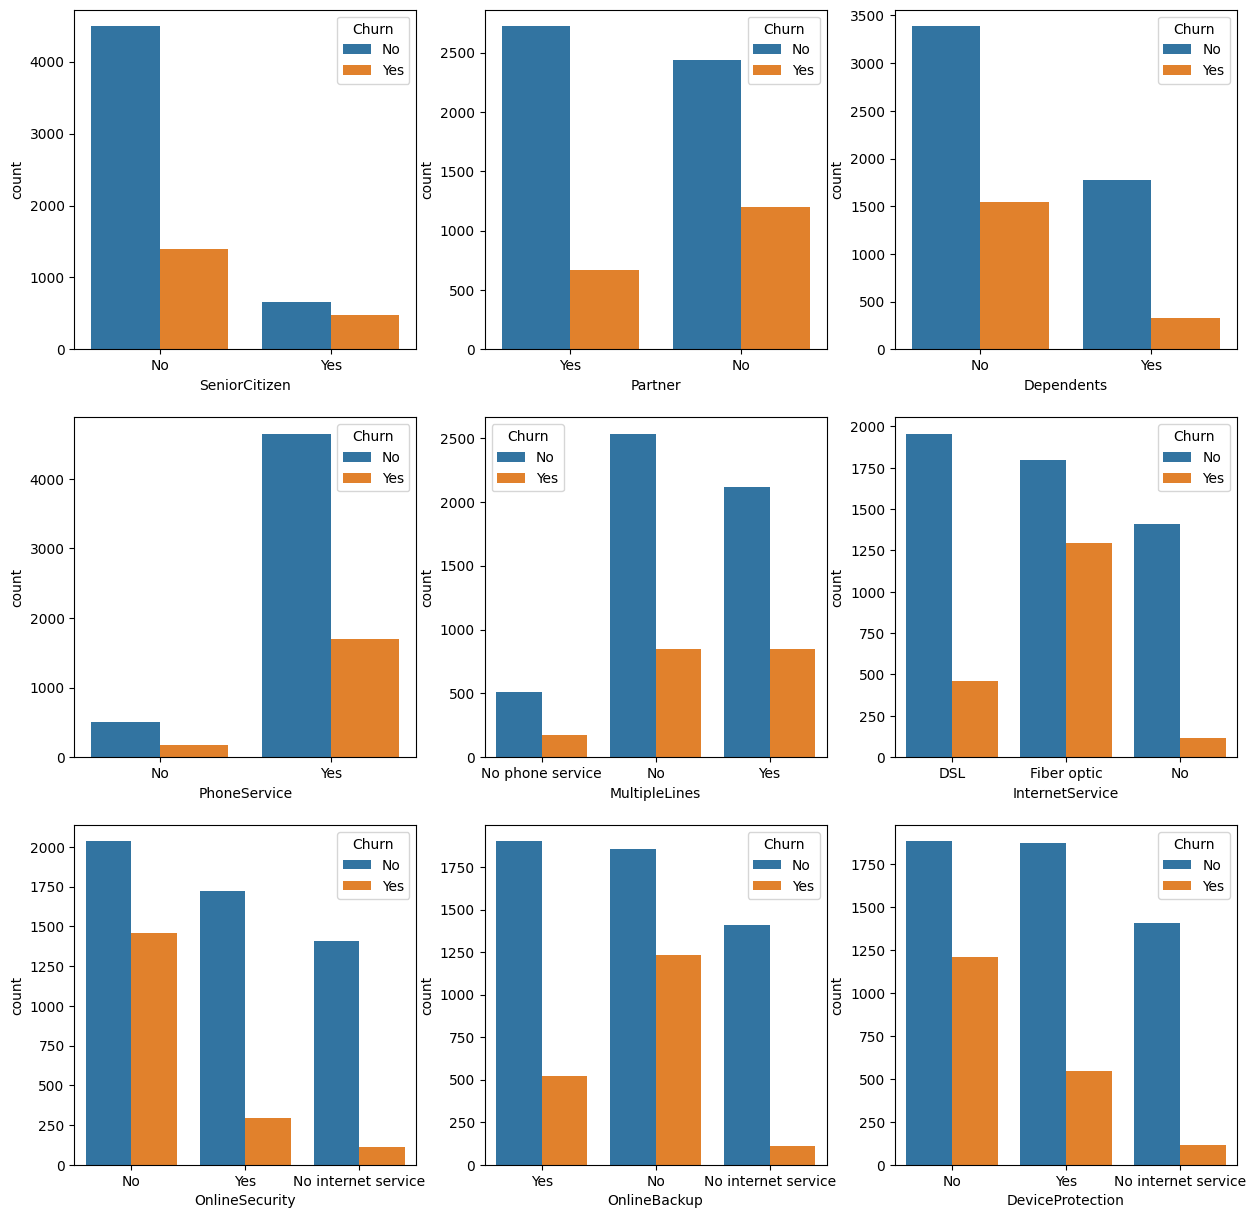

In [540]:
fig, axes = plt.subplots(3,3, figsize=(15,15))
for cat, ax in zip(kategorik[1:10], axes.flatten()):
    sns.countplot(data=df, x=cat, hue='Churn', ax= ax)

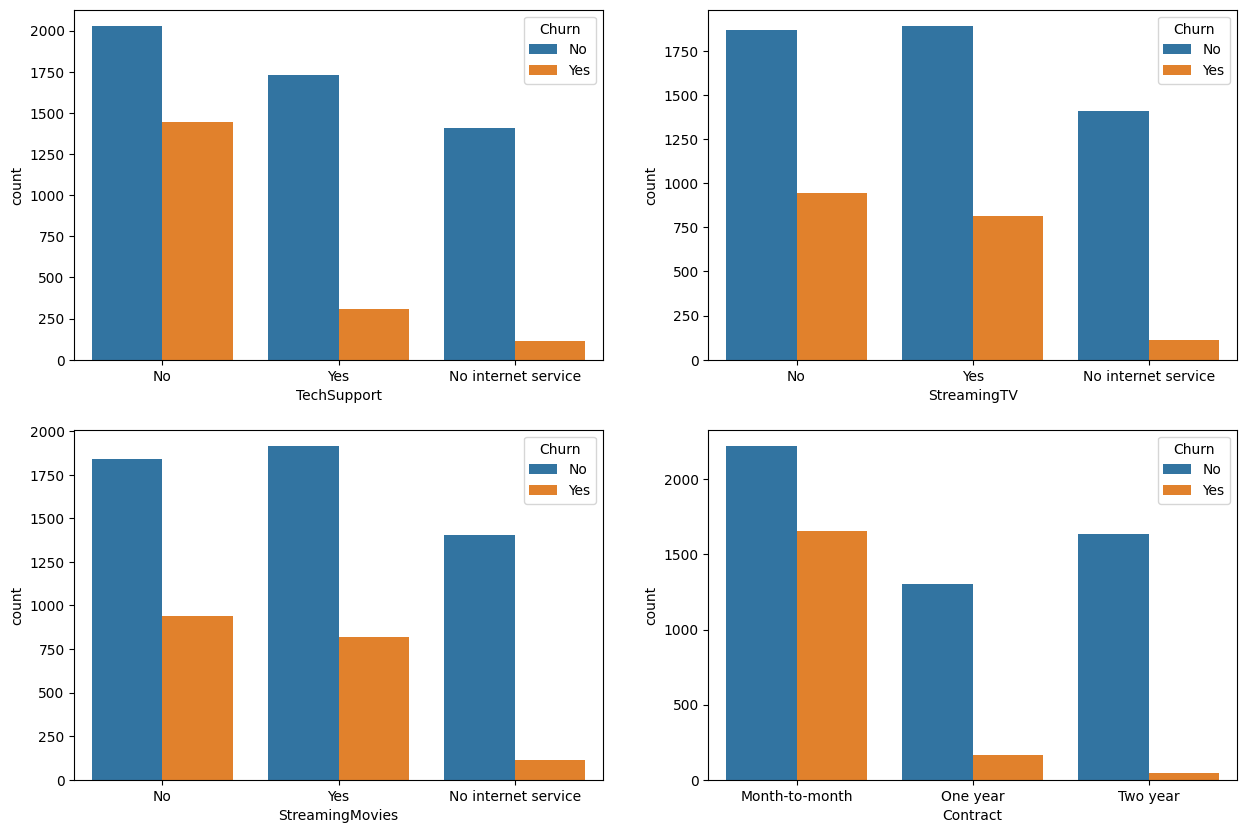

In [541]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
for cat, ax in zip(kategorik[10:-2], axes.flatten()):
    sns.countplot(data=df, x=cat, hue='Churn', ax= ax)

##### - Customer yang memiliki keluarga ataupun tidak memiliki keluarga tidak terlalu mempengaruhi churn rate, dimana customer masih lebih banyak yang setia daripada yang pindah
##### - Product atau layanan yang ditawarkan juga memiliki tingkat churn rate yang rendah, harus lebih waspada pada internet service (fiber optik) kemungkinan banyak customer yang tidak senang dengan kualitas layanan yang diberikan
##### - Begitu pula dengan Streaming TV dan movies yang angka churn ratenya masih dibawah standar, tapi tetap harus waspada.
##### - Untuk layanan security atau support yang lainnya juga harus diwaspadai, dimana customer yang tidak menggunakan layanan security dan support lainnya memiliki angka churn yang tinggi.

<AxesSubplot: xlabel='PaymentMethod', ylabel='count'>

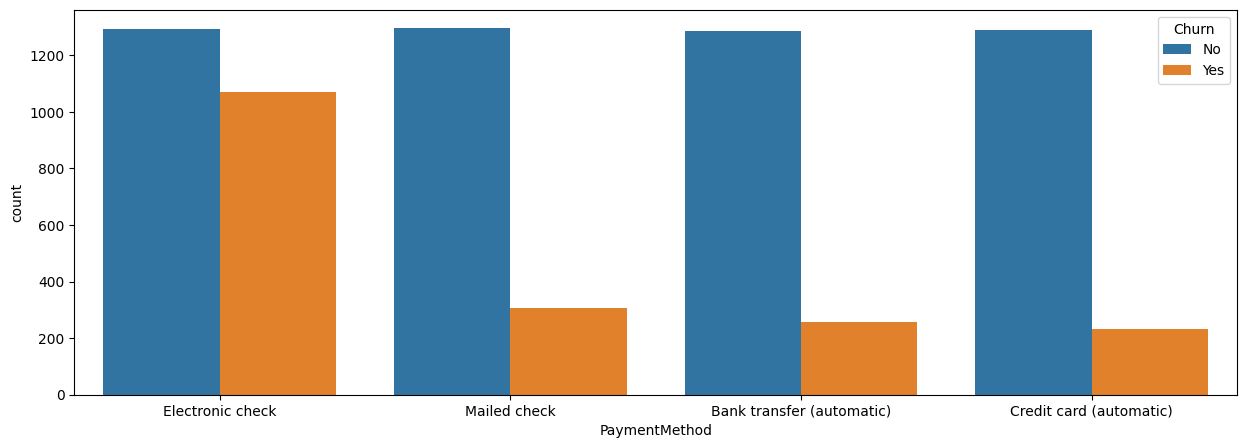

In [542]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='PaymentMethod', hue='Churn')

##### - Customer dengan pembayaran Electronic Check memiliki churn rate yang tinggi, sehingga harus melakukan sebuah perubahan.

# 6. Data Preprocessing

##### Membuat salinan dari df untuk backup

In [543]:
df_new = df.copy()

##### Menghapus customerID, yang dinilai tidak berpengaruh pada prediksi

In [544]:
df_new = df_new.drop(columns='customerID')

##### Mengubah Churn menjadi categorical ordinal

In [545]:
df_new['Churn'] = np.where(df_new['Churn'] == 'No', 0, 1)

## A. Splitting Dataset

In [546]:
X = df_new.drop(columns="Churn")
y = df_new["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)   
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 17), (1407, 17), (5625,), (1407,))

## B. Pipeline

In [547]:
numerical_pipe = Pipeline([
    ('scaler', MinMaxScaler())
])

category_pipe = Pipeline([
    ('scaler', OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ('nume_pipe', numerical_pipe, ['tenure', 'MonthlyCharges', 'TotalCharges']),
    ('cate_pipe', category_pipe, ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
                                  ])
])

last_pipe= Pipeline([
    ('prep', preprocessing),
    ('algo', XGBClassifier(n_jobs =-1, random_state = 41))
])

# 7. Modelling

In [548]:
model = RandomizedSearchCV(last_pipe, rsp.xgb_params, cv=4, n_iter=50, n_jobs=-1, verbose=0, random_state=41)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__colsample_bytree': 0.8863539623696491, 'algo__gamma': 8, 'algo__learning_rate': 0.013773392876858385, 'algo__max_depth': 6, 'algo__n_estimators': 198, 'algo__reg_alpha': 0.0033959365619531806, 'algo__reg_lambda': 0.03828285142390281, 'algo__subsample': 0.6619870715149733}
0.8177777777777778 0.8048011820596267 0.7917555081734187


# 8. Model Inference

In [549]:
temp = []
for i in X_train:
    x = np.random.randint(0,len(df[i].unique()),size=(1, 10))
    for j in x:
        temp.append(df[i].unique()[j])
        
df_inf = pd.DataFrame(temp)
df_inf = df_inf.set_index(X_train.columns).T

In [550]:
pred   = model.predict(df_inf)
pred   = np.where(pred == 0, 'No', 'Yes')
pd.DataFrame(pred).transpose()

,0,1,2,3,4,5,6,7,8,9
0,No,No,No,No,No,No,No,No,No,No


# 9. Coclusion

# A. EDA

* Customer lebih banyak yang setia dibandingkan dengan yang pindah.
* Kebanyakan customer memiliki tenor 1 bulan, namun 2/3 dari mereka pindah pada bulan berikutnya
* Serta customer yang memiliki tenor 1 bulan, kebanyakan hanya menggunakan layanan phone service
* Semakin lama tenure customer, maka persentase mereka bertahan semakin tinggi
* Berdasarkan layanan yang ditawarkan, tingkat churn rate terbilang rendah namun tetap harus waspada terutama pada layanan internet. Besar kemungkinan bahwa salah satu penyebab customer pindah karena layanan internet yang tidak stabil khususnya fiber optik.
* Churn rate pada Layanan Streaming TV dan Movies masih terbilang aman, namun tetap harus waspada dan tetap meningkatkan kualitas.
* Untuk layanan security atau support yang lainnya juga harus diwaspadai, dimana customer yang tidak menggunakan layanan security dan support lainnya memiliki angka churn yang tinggi.

## B. Model Analysis

* Model menggunakan XGBoost Classifier dan tidak overfit, namun tetap harus ditingkatkan karena kemungkinan akan mengalami overfit jika data berubah.
* Model mampu memprediksi data yang baru, dengan hasil prediksi bahwa semua customer tidak pindah / churn.